## Solving the Double Pendulum Problem in Python

Importing the Essential Libraries

In [ ]:
import numpy as np
from scipy.integrate import odeint
import sympy as sm

Defining Symbols and Variables Using `sympy.symbols()`

In [26]:
t = sm.symbols('t')

m_1, m_2, g = sm.symbols('m_1 m_2 g', positive=True)

the1, the2 = sm.symbols(r'\theta_1, \theta_2', cls=sm.Function) # sm.Function states that the position is a function

the1 = the1(t) # Specifying the variable
the2 = the2(t)

x1 = sm.sin(the1)
y1 = -sm.cos(the1)

x2 = x1 + sm.sin(the2)
y2 = y1 + -sm.cos(the2)

x1

sin(\theta_1(t))

Calculating the first and second derivative of $\theta_i$: $\frac{d\theta_i}{dt}$ and $\frac{d^2\theta_i}{dt^2}$, As well as ${v_x}_i$ and ${v_y}_i$ (for Energies) using `sympy.diff()`

i = 1 -> for the $1^{st}$ mass

i = 2 -> for the $2^{nd}$ mass


In [28]:
the1_d = sm.diff(the1, t) # Angular Velocity
the1_dd = sm.diff(the1_d, t) # Angular Acceleration

x1_d = sm.diff(x1, t)
y1_d = sm.diff(y1, t)

the2_d = sm.diff(the2, t) # Angular Velocity
the2_dd = sm.diff(the2_d, t) # Angular Acceleration

x2_d = sm.diff(x2, t)
y2_d = sm.diff(y2, t)


Defining Kinetic $T$ and Potential Energies $V$ and the Lagrangian $L$ for the double pendulum for each mass.

$ T = \frac{1}{2} \ m \ ((\frac{dx(t)}{dt})^2 + (\frac{dy(t)}{dt})^2) $ 

$ V = m \ g \ y(t) $

$ L = T - V $

In [30]:
T_1 = 1/2 * m_1 * ((x1_d)**2+(y1_d)**2)
T_2 = 1/2 * m_2 * ((x2_d)**2+(y2_d)**2)

V_1 = m_1 * g * y1
V_2 = m_2 * g * y2

L = T_1 + T_2 - (V_2 + V_1)

We formulate Lagrange's Equation for a non-damped system, since we have two mass, we have two equations $q = \{\theta_1, \theta_2 \}$:

$ \frac{d}{dt} \left(\frac{\partial L}{\partial \dot{\theta_1}}\right) - \frac{\partial L}{\partial \theta_1} = 0
 $

$ \frac{d}{dt} \left(\frac{\partial L}{\partial \dot{\theta_2}}\right) - \frac{\partial L}{\partial \theta_2} = 0
 $



In [31]:

LE1 = sm.diff(sm.diff(L, the1_d), t) - sm.diff(L, the1)
LE2 = sm.diff(sm.diff(L, the2_d), t) - sm.diff(L, the2)

# use .simplyfy() if necessary
LE1 = LE1.simplify()
LE2 = LE2.simplify()


g*m_1*sin(\theta_1(t)) + g*m_2*sin(\theta_1(t)) + m_1*Derivative(\theta_1(t), (t, 2)) + m_2*sin(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), t)**2 + m_2*cos(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), (t, 2)) + m_2*Derivative(\theta_1(t), (t, 2))

We create a function that solves Lagrange's equation numerically for the double pendulum system.

- **`sm.solve([LE1, LE2], the1_dd, the2_dd)`:** This solves the equations `LE1` and `LE2` for `the1_dd` and `the2_dd` respectively. The result is an array containing the solutions:

$\frac{d^2 \theta_1}{dt^2} = ...$ `# solutions[the1_dd]`

$\frac{d^2 \theta_2}{dt^2} = ...$ `# solutions[the2_dd]`


We convert the symbolic solutions into numerical functions using `sm.lambdify()`, it takes the specified variables as input and computes the second derivative of the position with respect to time according to Lagrange's equation.

In [34]:
solutions = sm.solve([LE1, LE2], the1_dd, the2_dd)
LEF1 = sm.lambdify((the1, the2, the1_d, the2_d, t, m_1, m_2, g), solutions[the1_dd])
LEF2 = sm.lambdify((the1, the2, the1_d, the2_d, t, m_1, m_2, g), solutions[the2_dd])


We solve our problem numerically using `odeint()` the provided function of `scipy.integrate`.
We are interessted in finding the angles and angular velocities of the two mass in form of a vector:

$ \vec{y} = (\theta_1, \dot{\theta_1}, \theta_2, \dot{\theta_2})$

In numerical analysis, the Runge–Kutta are a family of implicit and explicit iterative methods, which include the Euler method, used in temporal discretization for the approximate solutions of simultaneous nonlinear equations.

$ \vec{y}_{n+1} = \vec{y}_{n} + \Delta t \ f(y_n, t) $

To make it simpler think of it as the Euler Method:

$ \vec{y}_{n+1} = \vec{y}_{n} + \Delta t \ \frac{d\vec{y}}{dt} $

In other words, we have the following numerical scheme:

$ {\theta_1}_{i+1} = {\theta_1}_{i} + \Delta t \ \frac{d\theta_1}{dt} $

$ \dot{\theta_1}_{i+1} = \dot{\theta_1}_{i} + \Delta t \ \frac{d^2\theta_1}{dt^2} $

$ {\theta_2}_{i+1} = {\theta_2}_{i} + \Delta t \ \frac{d\theta_2}{dt} $

$ \dot{\theta_2}_{i+1} = \dot{\theta_2}_{i} + \Delta t \ \frac{d^2\theta_2}{dt^2} $

In other words:

$ \vec{y}_{i+1} = \vec{y}_{i} + \Delta t \ \frac{d\vec{y}}{dt} $


In [35]:
# Initial conditions & Constants
initial_conditions = [1.0, 0.0, 1.0, 0.0]  # Angle_1, Velocity_1, Angle_2, Velocity_2, 
m1_val = 1
m2_val = 1
g_val = 9.81

# Function representing the system of first-order ODEs
def system_of_odes(y, t, m_1, m_2, g):
    the1, the1_d, the2, the2_d = y

    the1_dd = LEF1(the1, the2, the1_d, the2_d, t, m_1, m_2, g)
    the2_dd = LEF2(the1, the2, the1_d, the2_d, t, m_1, m_2, g)

    return [the1_d, the1_dd, the2_d, the2_dd]

# Time points for numerical solution
time_points = np.linspace(0, 40, 1001)

# Solve the system of ODEs
solution = odeint(system_of_odes, initial_conditions, time_points, args=(m1_val, m2_val, g_val))

# [ [the1_0, the1_d_0, the2_0, the2_d_0], t=0
#   [the1_1, the1_d_1, the2_1, the2_d_1], t=t1
#   [the1_2, the1_d_2, the2_2, the2_d_2], t=t2
# ...

# Extract position and velocity from the solution
the1_sol = solution[:, 0]
the1_d_sol = solution[:, 1]

the2_sol = solution[:, 2]
the2_d_sol = solution[:, 3]

x1_pendulum = np.sin(the1_sol)
y1_pendulum = -np.cos(the1_sol)

x2_pendulum = x1_pendulum + np.sin(the2_sol)
y2_pendulum = y1_pendulum + -np.cos(the2_sol)


array([ 0.84147098,  0.83788971,  0.8269928 , ..., -0.65932389,
       -0.70516272, -0.74334979])

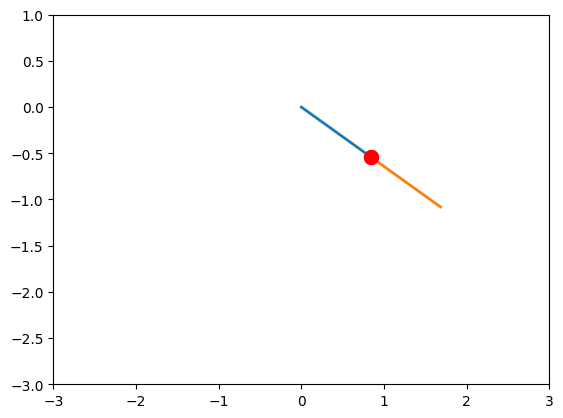

In [36]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def update(frame):
    pendulum1.set_data([0, x1_pendulum[frame]], [0, y1_pendulum[frame]])
    mass1.set_data([x1_pendulum[frame]], [y1_pendulum[frame]])

    pendulum2.set_data([x1_pendulum[frame], x2_pendulum[frame]], [y1_pendulum[frame], y2_pendulum[frame]])
    mass2.set_data([x1_pendulum[frame]], [y1_pendulum[frame]])

    return pendulum1, mass1

fig, ax = plt.subplots()
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 1)

pendulum1, = ax.plot([0, x1_pendulum[0]], [0, y1_pendulum[0]], lw=2)
mass1, = ax.plot([x1_pendulum[0]], [y1_pendulum[0]], 'o', markersize=10, color='red')

pendulum2, = ax.plot([x1_pendulum[0], x2_pendulum[0]], [y1_pendulum[0], y2_pendulum[0]], lw=2)
mass2, = ax.plot([x2_pendulum[0]], [y2_pendulum[0]], 'o', markersize=10, color='red')

animation = FuncAnimation(fig, update, frames=len(time_points), interval=50, blit=True)

plt.show()
